In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from rest.utils import *

import numpy as np
import casadi as ca

import cdd

In [ ]:
from scipy.spatial import ConvexHull, QhullError

# Derived class for Tube-based Robust MPC Controller
class LinearRMPCController(MPCController):
    def __init__(
            self, 
            env: Env, 
            dynamics: Dynamics, 
            Q: np.ndarray, 
            R: np.ndarray, 
            Qf: np.ndarray, 
            freq: float, 
            N: int, 
            K_feedback: Optional[np.ndarray] = None,  # Feedback gain for tube
            disturbance_bounds: Optional[Tuple[np.ndarray, np.ndarray]] = None,  # (lbz, ubz) of D
            name: str = 'RMPC', 
            type: str = 'RMPC', 
            verbose: bool = True
        ) -> None:

        super().__init__(env, dynamics, Q, R, Qf, freq, N, name, type, verbose)

        x0 = np.zeros(self.dynamics.dim_states)
        u0 = np.zeros(self.dynamics.dim_inputs)
        self.A, self.B = self.dynamics.get_linearized_AB_discrete(x0, u0, self.dt)

        # Automatically solve DARE if no K provided
        if K_feedback is None:
            from scipy.linalg import solve_discrete_are
            P = solve_discrete_are(self.A, self.B, Q, R)
            self.K_feedback = -np.linalg.inv(R + self.B.T @ P @ self.B) @ self.B.T @ P @ self.A
        else:
            self.K_feedback = K_feedback

        # Compute Omega_tube from disturbance box D 
        if disturbance_bounds is not None:

            disturbance_lbs = disturbance_bounds[0]
            disturbance_ubs = disturbance_bounds[1]

        elif self.env.disturbance_lbs is not None and self.env.disturbance_ubs is not None:

            disturbance_lbs = self.env.disturbance_lbs
            disturbance_ubs = self.env.disturbance_ubs
            
        else:
            raise ValueError("No bounds of additivec disturbances provided, can not initialize RMPC")
        
        disturbance_lbs /= freq
        disturbance_ubs /= freq
        
        self.Omega_tube = self.compute_invariant_tube(self.A + self.B @ self.K_feedback, disturbance_lbs, disturbance_ubs)
        self.A_omega, self.b_omega = self.convert_vertices_to_H(self.Omega_tube)
        self.tube_bounds_x = self.estimate_bounds_from_polytope(self.Omega_tube)
        self.tube_bounds_u = np.abs(self.K_feedback @ self.tube_bounds_x)

        if self.verbose:
            print(f"Tube size x: {self.tube_bounds_x}")
            print(f"Tube size u: {self.tube_bounds_u}")

        self.setup()
        
    
    def compute_invariant_tube(self, A_cl, lbz, ubz, tol=1e-4, max_iter=1000):
        """Compute Omega_tube via Minkowski recursion."""
        from scipy.spatial import ConvexHull
        import itertools

        print(f"A_cl: {A_cl}")

        def apply_affine(points, A):
            return np.dot(points, A.T)

        def minkowski_sum(P, Q):
            return np.array([p + q for p, q in itertools.product(P, Q)])

        # Initial set: D is a box defined by lbz, ubz
        D = np.array(list(itertools.product(*zip(lbz, ubz))))
        Omega = D.copy()

        for _ in range(max_iter):

            new_points = minkowski_sum(apply_affine(Omega, A_cl), D)

            try:
                new_hull = ConvexHull(new_points)
                new_vertices = new_points[new_hull.vertices]
            except QhullError:
                min_bounds = np.min(new_points, axis=0)
                max_bounds = np.max(new_points, axis=0)
                new_vertices = np.array(list(itertools.product(*zip(min_bounds, max_bounds))))

            old_box = self.estimate_bounds_from_polytope(Omega)
            new_box = self.estimate_bounds_from_polytope(new_vertices)

            #print(f"new_box: {new_box}")

            if np.allclose(old_box, new_box, atol=tol):
                return new_vertices

            Omega = new_vertices

        return Omega
    
    def convert_vertices_to_H(self, vertices: np.ndarray):
        """
        Convert V-representation (vertices) to H-representation (A x <= b)
        using convex hull.
        """
        from scipy.spatial import ConvexHull

        hull = ConvexHull(vertices)
        A = hull.equations[:, :-1]
        b = -hull.equations[:, -1]
        return A, b

    def estimate_bounds_from_polytope(self, vertices):
        """Estimate box bounds from polytope vertices (axis-aligned)."""
        return np.max(np.abs(vertices), axis=0)

    def setup(self) -> None:

        super().setup()  # Setup nominal MPC

        # Expand initial state constraints (not here, do online)
        # Add Omega constraints on initial state x0: A x0 <= b
        self.ocp.dims.nh_0 = self.A_omega.shape[0]
        self.ocp.model.con_h_expr_0 = ca.mtimes(self.A_omega, self.ocp.model.x)
        self.ocp.constraints.lh_0 = -1e6 * np.ones(self.A_omega.shape[0])
        self.ocp.constraints.uh_0 = 1e6 * np.ones(self.A_omega.shape[0])  # placeholder

        # Shrink state constraints
        if self.env.state_lbs is not None:
            #self.ocp.constraints.lbx_0 -= self.tube_bounds_x
            self.ocp.constraints.lbx += self.tube_bounds_x
            self.ocp.constraints.lbx_e += self.tube_bounds_x
        
        if self.env.state_ubs is not None:
            #self.ocp.constraints.ubx_0 += self.tube_bounds_x
            self.ocp.constraints.ubx -= self.tube_bounds_x
            self.ocp.constraints.ubx_e -= self.tube_bounds_x

        # Shrink input constraints
        if self.env.input_lbs is not None:
            self.ocp.constraints.lbu += self.tube_bounds_u
        if self.env.input_ubs is not None:
            self.ocp.constraints.ubu -= self.tube_bounds_u

        # Recreate solver with tightened constraints
        self.solver = AcadosOcpSolver(self.ocp, json_file=f"{self.name}.json", generate=True)
        if self.verbose:
            print("Tube-based MPC setup with constraint tightening completed.")

    @check_input_constraints
    def compute_action(self, current_state: np.ndarray, current_time) -> np.ndarray:

        # Disable the constraint for initial state defined before
        self.solver.constraints_set(0, "lbx", current_state-self.tube_bounds_x)
        self.solver.constraints_set(0, "ubx", current_state+self.tube_bounds_x)

        # Set upper limit of convex set equality constraint on target step to be 0
        uh_dynamic = self.b_omega + self.A_omega @ current_state
        self.solver.constraints_set(0, "uh", uh_dynamic)

        #self.plot_polytope_from_Ab_2d(self.A_omega, uh_dynamic)
        #raise ValueError("Polytope plot")   

        # Set tracking references
        state_ref = self.target_state
        input_ref = np.zeros(self.dim_inputs)
        for i in range(self.N):
            self.solver.set(i, "yref", np.concatenate((state_ref, input_ref)))
        self.solver.set(self.N, "yref", state_ref)

        status = self.solver.solve()

        x_nominal = self.solver.get(0, "x")
        u_nominal = self.solver.get(0, "u")

        # Apply tube feedback control
        u_real = u_nominal + self.K_feedback @ (current_state - x_nominal)

        if self.verbose:
            print("Current state:", current_state)
            print("Nominal state:", x_nominal)
            print("Nominal input:", u_nominal)
            print("Tube-corrected input:", u_real)

        # Also return nominal predictions
        x_pred = np.zeros((self.N + 1, self.dim_states))
        u_pred = np.zeros((self.N, self.dim_inputs))
        for i in range(self.N + 1):
            x_pred[i, :] = self.solver.get(i, "x")
            if i < self.N:
                u_pred[i, :] = self.solver.get(i, "u")

        return u_real, x_pred, u_pred, u_nominal
    
    def plot_2d(self, title="Invariant Set Ω and Bounding Box"):
        """
        Plot the 2D invariant set (Ω) and its axis-aligned bounding box.
        Assumes 2D state space.
        """
        Omega_vertices = self.Omega_tube
        assert Omega_vertices.shape[1] == 2, "Only 2D invariant sets are supported."

        # Convex hull of the Omega polytope
        hull = ConvexHull(Omega_vertices)
        hull_pts = Omega_vertices[hull.vertices]

        # Compute axis-aligned bounding box
        min_bounds = np.min(Omega_vertices, axis=0)
        max_bounds = np.max(Omega_vertices, axis=0)
        bounding_box = np.array([
            [min_bounds[0], min_bounds[1]],
            [min_bounds[0], max_bounds[1]],
            [max_bounds[0], max_bounds[1]],
            [max_bounds[0], min_bounds[1]],
            [min_bounds[0], min_bounds[1]]
        ])

        # Plot
        plt.figure(figsize=(6, 6))
        plt.fill(hull_pts[:, 0], hull_pts[:, 1], color='skyblue', alpha=0.5, label='Ω (Invariant Set)')
        plt.plot(hull_pts[:, 0], hull_pts[:, 1], 'b-', linewidth=2)
        plt.plot(bounding_box[:, 0], bounding_box[:, 1], 'r--', linewidth=2, label='Bounding Box')

        plt.title(title)
        plt.xlabel("State x₁")
        plt.ylabel("State x₂")
        plt.axis('equal')
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_polytope_from_Ab_2d(self, A: np.ndarray, b: np.ndarray, title="Polytope from $Ax \leq b$"):

        assert A.shape[1] == 2, "only 2D polytopes are supported."
        assert b.shape[0] == A.shape[0], "Dimension of b must match number of rows in A"

        # Step 1: H → V-representation
        H = np.hstack([b.reshape(-1, 1), -A])
        mat = cdd.Matrix(H, number_type='float')
        mat.rep_type = cdd.RepType.INEQUALITY
        poly = cdd.Polyhedron(mat)
        generators = poly.get_generators()
        vertices = np.array([row[1:] for row in generators if row[0] == 1]) 

        # Step 2: Convex hull of the vertices
        hull = ConvexHull(vertices)
        hull_pts = vertices[hull.vertices]

        # Step 3: Plotting
        plt.figure(figsize=(6, 6))
        plt.fill(hull_pts[:, 0], hull_pts[:, 1], color='lightgreen', alpha=0.5, label='Ω (Polytope)')
        plt.plot(hull_pts[:, 0], hull_pts[:, 1], 'g-', linewidth=2)

        plt.title(title)
        plt.xlabel("x₁")
        plt.ylabel("x₂")
        plt.axis('equal')
        plt.grid(True)
        plt.legend()
        plt.show()

        return hull, vertices

In [3]:
np.random.seed(8042)

In [4]:

# Define profile of slope, the initial / target state
case = 1 # 1 or 2
initial_position = -0.5
initial_velocity = 0.0
target_position = 0.6
target_velocity = 0.0

# Define the physical boundary condition
state_lbs = np.array([-2.0, -4.0])
state_ubs = np.array([2.0, 4.0])
input_lbs = -8.0
input_ubs = 8.0

disturbance_lbs = np.array([-0.4, -0.8])
disturbance_ubs = np.array([0.4, 0.8])

# Instantiate class 'Env'
# Arguments (without constraints): 
#   1) case: $n \in [1, 2, 3, 4]$, type: int
#   2) initial state: x_0 = [p_0, v_0], type: np.array
#   3) terminal state: x_T = [p_T, v_T], type: np.array
env = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]),
          state_lbs=state_lbs, state_ubs=state_ubs, input_lbs=input_lbs, input_ubs=input_ubs,
          disturbance_lbs=disturbance_lbs, disturbance_ubs=disturbance_ubs)
#env.test_env() #  shape of slope (left side) and theta curve (right side) 

# Instantiate class 'Dynamics'
# Arguments: 
#   1) an object of class `Env`, type: Env  
dynamics = Dynamics(env)

# Define weight matrix in stage and terminal cost and the horizon for MPC 
Q = np.diag([1, 1])
R = np.array([[0.1]])
Qf = Q

# Define parameters of simulation
freq = 5 # controll frequency
t_terminal = 8 # time length of simulation

N = 15

In [5]:
# Define the MPC controller
controller_mpc = MPCController(env, dynamics, Q, R, Qf, freq, N, name='MPC')

# Instantiate the simulator, run the simulation, and plot the results
simulator_mpc = Simulator(dynamics, controller_mpc, env, 1/freq, t_terminal)
simulator_mpc.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_mpc = Visualizer(simulator_mpc)
#visualizer_mpc.display_plots()

Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_MPC.so
rm -f acados_solver_MPC.o
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o acados_solver_MPC.o acados_solver_MPC.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o MPC_model/MPC_expl_ode_fun.o MPC_model/MPC_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include 

Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
A_cl: [[ 0.95753892  0.14082748]
 [-0.42461083  0.40827482]]
Tube size x: [0.82233419 0.80440267]
Tube size u: [4.12578662]
MPC setup with Acados completed.
field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_LinearRMPC.so
rm -f LinearRMPC_constraints/LinearRMPC_constr_h_0_fun_jac_uxt_zt.o LinearRMPC_constraints/LinearRMPC_constr_h_0_fun.o acados_solver_LinearRMPC.o
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o LinearRMPC_constraints/LinearRMPC_constr_h_0_fun_jac_uxt_zt.o LinearRMPC_constraints/LinearRMPC_constr_h_0_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/ho

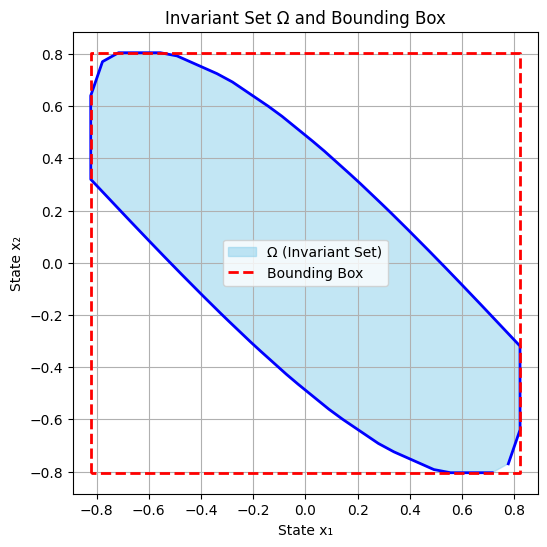

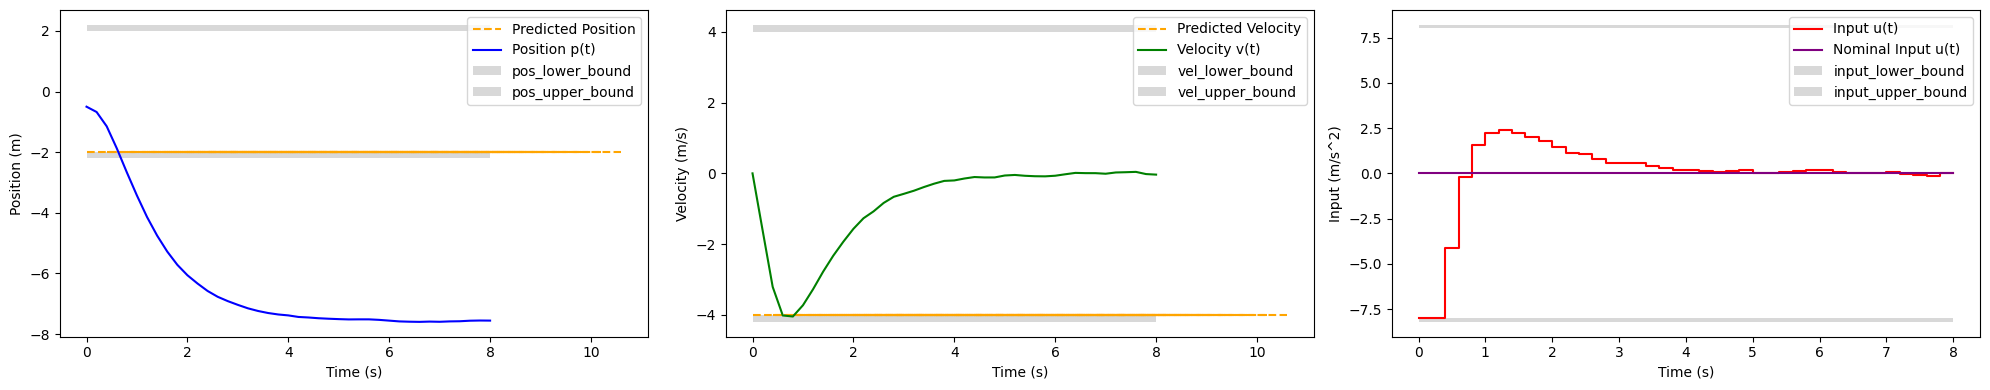

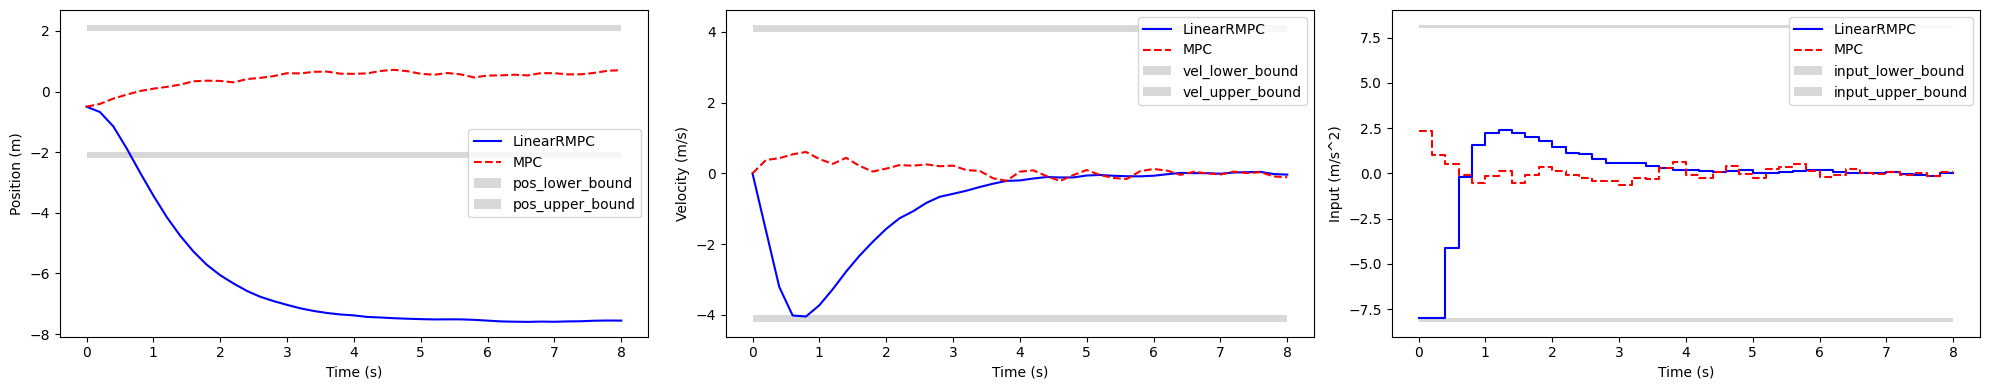

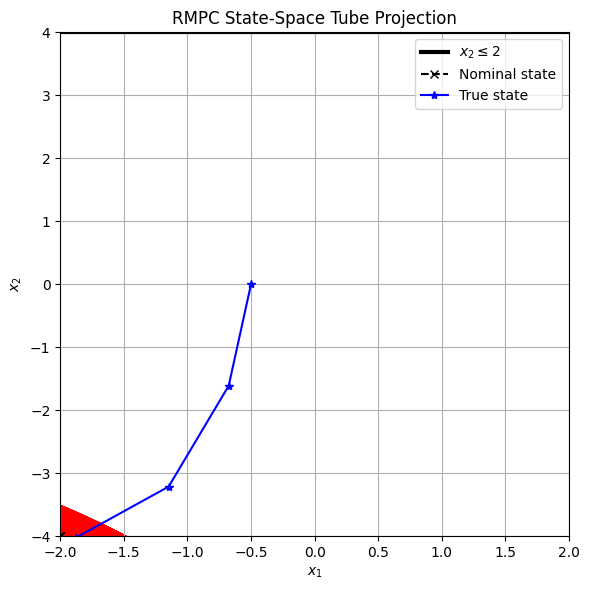

In [6]:
# Define the RMPC controller
controller_rmpc = LinearRMPCController(env, dynamics, Q, R, Qf, freq, N, name='LinearRMPC')

# Instantiate the simulator, run the simulation, and plot the results
simulator_rmpc = Simulator(dynamics, controller_rmpc, env, 1/freq, t_terminal)
simulator_rmpc.run_simulation()

controller_rmpc.plot_2d()

# Instantiate the visualizer, and display the plottings and animation
visualizer_rmpc = Visualizer(simulator_rmpc)
visualizer_rmpc.display_plots()
visualizer_rmpc.display_contrast_plots(simulator_mpc)
visualizer_rmpc.display_phase_portrait()